In [1]:
%pylab inline
from scipy.interpolate import interpn
from helpFunctions import surfacePlot
from constant import *
from multiprocessing import Pool
from functools import partial
import warnings
import math
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the policy funciton 
Vgrid_renting = np.load("Vgrid_renting.npy") 
cgrid_renting = np.load("cgrid_renting.npy") 
bgrid_renting = np.load("bgrid_renting.npy") 
kgrid_renting = np.load("kgrid_renting.npy") 
hgrid_renting = np.load("hgrid_renting.npy") 
Mgrid_renting = np.load("Mgrid_renting.npy") 
Hgrid_renting = np.load("Hgrid_renting.npy") 

V1000 = np.load("Vgrid1000.npy") 
V1500 = np.load("Vgrid1500.npy") 
V2000 = np.load("Vgrid2000.npy") 
V750 = np.load("Vgrid750.npy") 

cgrid1000 = np.load("cgrid1000.npy")
bgrid1000 = np.load("bgrid1000.npy")
kgrid1000 = np.load("kgrid1000.npy")
qgrid1000 = np.load("qgrid1000.npy")

cgrid1500 = np.load("cgrid1500.npy")
bgrid1500 = np.load("bgrid1500.npy")
kgrid1500 = np.load("kgrid1500.npy")
qgrid1500 = np.load("qgrid1500.npy")

cgrid2000 = np.load("cgrid2000.npy")
bgrid2000 = np.load("bgrid2000.npy")
kgrid2000 = np.load("kgrid2000.npy")
qgrid2000 = np.load("qgrid2000.npy")

cgrid750 = np.load("cgrid750.npy")
bgrid750 = np.load("bgrid750.npy")
kgrid750 = np.load("kgrid750.npy")
qgrid750 = np.load("qgrid750.npy")


indexH = [750, 1000, 1500, 2000]
cgrid = [cgrid750, cgrid1000, cgrid1500, cgrid2000]
bgrid = [bgrid750, bgrid1000, bgrid1500, bgrid2000]
kgrid = [kgrid750, kgrid1000, kgrid1500, kgrid2000]
qgrid = [qgrid750, qgrid1000, qgrid1500, qgrid2000]

In [3]:
import quantecon as qe
import timeit
mc = qe.MarkovChain(Ps)

H_options = [0, 750, 1000, 1500, 2000]
M_options = [0.2, 0.5, 0.8]
# wealth discretization 
ws = np.array([10,25,50,75,100,125,150,175,200,250,500,750,1000,1500,3000])
w_grid_size = len(ws)
# 401k amount discretization 
ns = np.array([1, 5, 10, 15, 25, 50, 100, 150, 400, 1000])
n_grid_size = len(ns)

def closest(lst, K): 
    '''
        Find the closest value of K in a list lst 
    '''
    lst = np.asarray(lst) 
    idx = (np.abs(lst - K)).argmin() 
    return lst[idx] 

def action_rent(t, x):
    w, n, e, s, z = x
    points = (ws, ns)
    c = interpn(points, cgrid_renting[:,:,e,s,z,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
    b = interpn(points, bgrid_renting[:,:,e,s,z,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
    k = interpn(points, kgrid_renting[:,:,e,s,z,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
    if e == 1:
        H = interpn(points, Hgrid_renting[:,:,e,s,z,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
        # decide to buy or not to buy a house
        H = H_options[np.sum(H>=np.array(H_options))-1] 
        if H == 0:
            h = interpn(points, hgrid_renting[:,:,e,s,z,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
            return (c,b,k,h)
        else:
            M = interpn(points, Mgrid_renting[:,:,e,s,z,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
            M = closest(H*M_options, M)
            return (c,b,k,M,H)
    else:
        h = interpn(points, hgrid_renting[:,:,e,s,z,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
        return (c,b,k,h)

def action_own(t, x):
    w, n, M, e, s, z, H = x
    # Mortgage amount, * 0.25 is the housing price per unit
    Ms = np.array([0.01*H,0.05*H,0.1*H,0.2*H,0.3*H,0.4*H,0.5*H,0.8*H]) * pt
    points = (ws,ns,Ms)
    c = interpn(points, cgrid[indexH.index(H)][:,:,:,e,s,z,t], x[:3], method = "nearest", bounds_error = False, fill_value = None)[0]
    b = interpn(points, bgrid[indexH.index(H)][:,:,:,e,s,z,t], x[:3], method = "nearest", bounds_error = False, fill_value = None)[0]
    k = interpn(points, kgrid[indexH.index(H)][:,:,:,e,s,z,t], x[:3], method = "nearest", bounds_error = False, fill_value = None)[0]
    q = interpn(points, qgrid[indexH.index(H)][:,:,:,e,s,z,t], x[:3], method = "nearest", bounds_error = False, fill_value = None)[0]
    if q <= 0.75:
        q = 0.5
    else:
        q = 1
    return (c,b,k,q)


def transition_to_rent(x,a,t,s_next):
    '''
        imput a is np array constains all possible actions 
        from x = [w, n, e, s, z] to x = [w, n, e, s, z]
    '''
    w, n, e, s, z = x
    c, b, k, h = a
    s = int(s)
    s_next = int(s_next)
    # transition of z
    if z == 1:
        z_next = 1
    else:
        if k == 0:
            z_next = 0
        else:
            z_next = 1 
    # variables used to collect possible states and probabilities
    x_next = []
    w_next =  b*(1+r_b[s]) + k*(1+r_k[s_next])
    n_next = gn(t, x, (r_b[s]+r_k[s_next])/2)
    if t >= T_R:
        return [w_next, n_next, 0, s_next, z_next]
    else:
        if e == 1:
            for e_next in [0,1]:
                x_next.append([w_next, n_next, e_next, s_next, z_next])
            prob_next = [Pe[s,e], 1 - Pe[s,e]]
        else:
            for e_next in [0,1]:
                x_next.append([w_next, n_next, e_next, s_next, z_next])
            prob_next = [1-Pe[s,e], Pe[s,e]]
        return x_next[np.random.choice(len(prob_next), 1, p = prob_next)[0]] 

def transition_to_own(x,a,t,s_next):
    '''
        imput a is np array constains all possible actions 
        from x = [w, n, e, s, z] to x = [w, n, M, e, s, z, H]
    '''
    w, n, e, s, z = x
    # variables used to collect possible states and probabilities
    x_next = []
    c, b, k, M, H = a
    s = int(s)
    s_next = int(s_next)
    # transition of z
    if z == 1:
        z_next = 1
    else:
        if k == 0:
            z_next = 0
        else:
            z_next = 1 
    M_next = M*(1+rh)
    w_next =  b*(1+r_b[s]) + k*(1+r_k[s_next])
    n_next = gn(t, x, (r_b[s]+r_k[s_next])/2)
    if t >= T_R:
        return [w_next, n_next, M_next, 0, s_next, z_next, H]
    else:
        if e == 1:
            for e_next in [0,1]:
                x_next.append([w_next, n_next, M_next, e_next, s_next, z_next, H])
            prob_next = [Pe[s,e], 1 - Pe[s,e]]
        else:
            for e_next in [0,1]:
                x_next.append([w_next, n_next, M_next, e_next, s_next, z_next, H])
            prob_next = [1-Pe[s,e], Pe[s,e]]
        return x_next[np.random.choice(len(prob_next), 1, p = prob_next)[0]] 

def transition_after_own(x, a, t, s_next):
    '''
    Input: state and action and time
    Output: possible future states and corresponding probability 
    '''
    w, n, M, e, s, z, H = x
    c,b,k,q = a
    # variables used to collect possible states and probabilities
    x_next = []
    m = M/D[T_max-t]
    M_next = M*(1+rh) - m
    # transition of z
    if z == 1:
        z_next = 1
    else:
        if k == 0:
            z_next = 0
        else:
            z_next = 1 
    
    n_next = gn(t, x, (r_b[s]+r_k[s_next])/2)
    w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[s_next])
    if t >= T_R:
        return [w_next, n_next, M_next, 0, s_next, z_next, H]
    else:
        if e == 1:
            for e_next in [0,1]:
                x_next.append([w_next, n_next, M_next, e_next, s_next, z_next, H])
            prob_next = [Pe[s,e], 1 - Pe[s,e]]
        else:
            for e_next in [0,1]:
                x_next.append([w_next, n_next, M_next, e_next, s_next, z_next, H])
            prob_next = [1-Pe[s,e], Pe[s,e]]
        return x_next[np.random.choice(len(prob_next), 1, p = prob_next)[0]]

In [4]:
'''
    Start with renting: 
    w = 5
    n  = 0
    e = 1
    s = 1
    1000 agents for 1 economy, 500 economies. 
'''
names = ['w', 'n', 'M', 'e', 's', 'z', 'H',
         'yt', 'c', 'b', 'k', 'q', 'h','live']
x0 = [5, 0, 1, 1, 0]
numAgents = 1000
numEcons = 500

In [5]:
import quantecon as qe
import random as rd
mc = qe.MarkovChain(Ps)
EconStates = [mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(numEcons)]

def simulation(i):
    track = np.zeros((T_max - T_min,len(names)))
    econState = EconStates[i//numAgents]
    alive = True
    x = x0
    for t in range(1,len(econState)-1):
        if rd.random() > Pa[t]:
            alive = False
        if alive:
            track[t, 13] = 1
            s_next = econState[t+1]
            # if is still renting
            if (len(x) == 5):
                a = action_rent(t,x)
                # continue to rent 
                if (len(a) == 4):
                    # x = [w,n,e,s,z]
                    # a = [c,b,k,h]
                    track[t, 0] = x[0]
                    track[t, 1] = x[1]
                    track[t, 2] = 0
                    track[t, 3] = x[2]
                    track[t, 4] = x[3]
                    track[t, 5] = x[4]
                    track[t, 6] = 0
                    track[t, 7] = y(t,x)
                    track[t, 8] = a[0]
                    track[t, 9] = a[1]
                    track[t, 10] = a[2]
                    track[t, 11] = 0
                    track[t, 12] = a[3]
                    x = transition_to_rent(x,a,t,s_next) 
                # switch to own 
                else:
                    # a = [c,b,k,M,H]
                    track[t, 0] = x[0]
                    track[t, 1] = x[1]
                    track[t, 2] = a[3]
                    track[t, 3] = x[2]
                    track[t, 4] = x[3]
                    track[t, 5] = x[4]
                    track[t, 6] = a[4]
                    track[t, 7] = y(t,x)
                    track[t, 8] = a[0]
                    track[t, 9] = a[1]
                    track[t, 10] = a[2]
                    track[t, 11] = 0
                    track[t, 12] = a[4]*(1+kappa)
                    x = transition_to_own(x,a,t,s_next)
                    
            # if owning a house already
            else:
                a = action_own(t, x)
                # x = [w,n,M,e,s,z,H]
                # a = [c,b,k,q]
                track[t, 0] = x[0]
                track[t, 1] = x[1]
                track[t, 2] = x[2]
                track[t, 3] = x[3]
                track[t, 4] = x[4]
                track[t, 5] = x[5]
                track[t, 6] = x[6]
                track[t, 7] = y(t,x)
                track[t, 8] = a[0]
                track[t, 9] = a[1]
                track[t, 10] = a[2]
                track[t, 11] = a[3]
                # calculate housing consumption
                if a[3] == 1:
                    Vh = (1+kappa)*x[6]
                else:
                    Vh = (1-kappa)*(x[6]/2)
                track[t, 12] = Vh
                x = transition_after_own(x, a, t, s_next)
    return track

In [6]:
%%time
pool = Pool()
agents = pool.map(simulation, list(range(numAgents*numEcons)))
pool.close()

CPU times: user 7.64 s, sys: 4.9 s, total: 12.5 s
Wall time: 42min 4s


In [7]:
ww = np.zeros((T_max-T_min, numAgents*numEcons))
nn = np.zeros((T_max-T_min, numAgents*numEcons))
MM = np.zeros((T_max-T_min, numAgents*numEcons))
ee = np.zeros((T_max-T_min, numAgents*numEcons))
ss = np.zeros((T_max-T_min, numAgents*numEcons))
ZZ = np.zeros((T_max-T_min, numAgents*numEcons))
HH = np.zeros((T_max-T_min, numAgents*numEcons))
ytyt = np.zeros((T_max-T_min, numAgents*numEcons))
cc = np.zeros((T_max-T_min, numAgents*numEcons))
bb = np.zeros((T_max-T_min, numAgents*numEcons))
kk = np.zeros((T_max-T_min, numAgents*numEcons))
qq = np.zeros((T_max-T_min, numAgents*numEcons))
hh = np.zeros((T_max-T_min, numAgents*numEcons))
live = np.zeros((T_max-T_min, numAgents*numEcons))

In [8]:
def separateAttributes(agents):
    for i in range(numAgents*numEcons):
        ww[:,i] = agents[i][:,0]
        nn[:,i] = agents[i][:,1]
        MM[:,i] = agents[i][:,2]
        ee[:,i] = agents[i][:,3]
        ss[:,i] = agents[i][:,4]
        ZZ[:,i] = agents[i][:,5]
        HH[:,i] = agents[i][:,6]
        ytyt[:,i] = agents[i][:,7]
        cc[:,i] = agents[i][:,8]
        bb[:,i] = agents[i][:,9]
        kk[:,i] = agents[i][:,10]
        qq[:,i] = agents[i][:,11]
        hh[:,i] = agents[i][:,12]
        live[:,i] = agents[i][:,13]
separateAttributes(agents)

In [9]:
def quantileForPeopleWholive(attribute, quantiles = [0.25, 0.5, 0.75]):
    qList = []
    for i in range(T_max):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            qList.append(np.array([0] * len(quantiles)))
        else:
            qList.append(np.quantile(attribute[i, np.where(live[i,:] == 1)], q = quantiles))
    return np.array(qList)
        
def meanForPeopleWholive(attribute):
    means = []
    for i in range(T_max):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            means.append(np.array([0]))
        else:
            means.append(np.mean(attribute[i, np.where(live[i,:] == 1)]))
    return np.array(means)

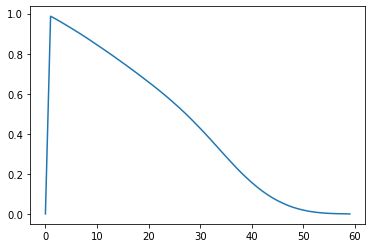

In [10]:
# Population during the entire simulation period
plt.plot(np.mean(live,axis = 1))

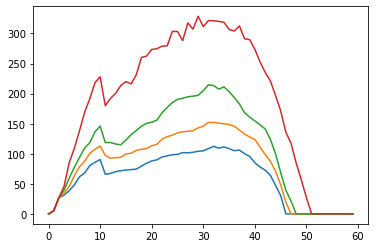

In [11]:
plt.plot(quantileForPeopleWholive(ww,[0.25,0.5,0.75,0.99]))

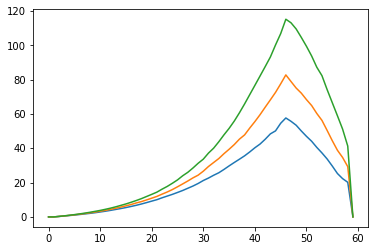

In [12]:
plt.plot(quantileForPeopleWholive(nn))

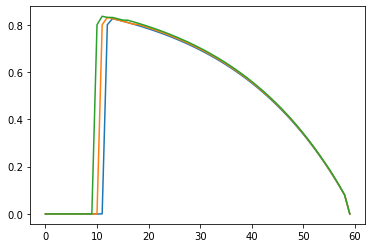

In [13]:
plt.plot(quantileForPeopleWholive(MM))

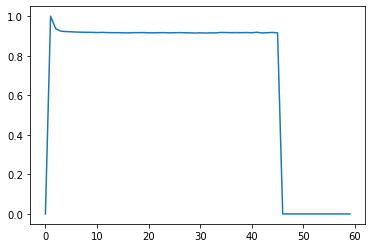

In [14]:
plt.plot(meanForPeopleWholive(ee))

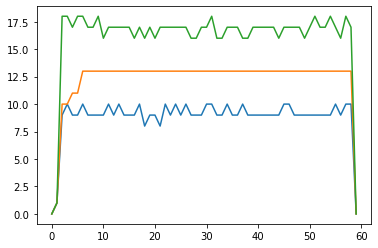

In [15]:
plt.plot(quantileForPeopleWholive(ss))

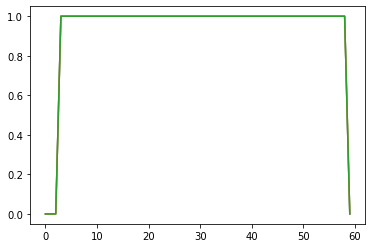

In [16]:
plt.plot(quantileForPeopleWholive(ZZ))

In [17]:
quantileForPeopleWholive(ZZ)[:,0]

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0.])

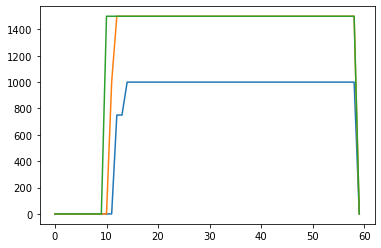

In [18]:
plt.plot(quantileForPeopleWholive(HH))

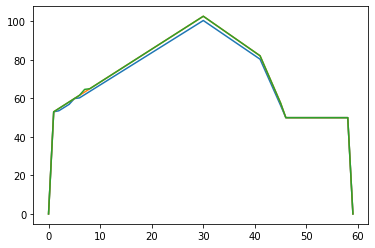

In [19]:
plt.plot(quantileForPeopleWholive(ytyt))

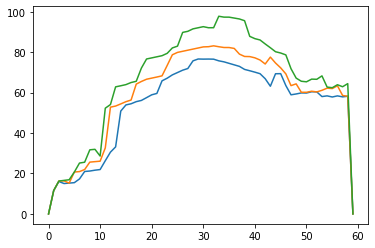

In [20]:
plt.plot(quantileForPeopleWholive(cc))

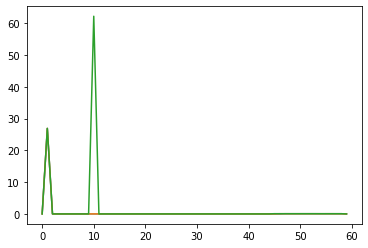

In [21]:
plt.plot(quantileForPeopleWholive(bb))

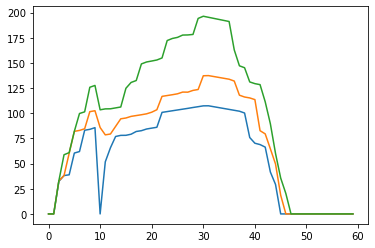

In [22]:
plt.plot(quantileForPeopleWholive(kk))

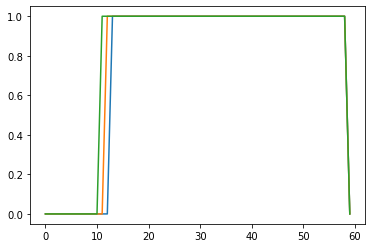

In [23]:
plt.plot(quantileForPeopleWholive(qq))

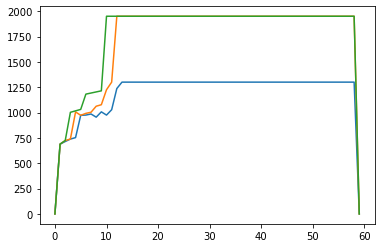

In [24]:
plt.plot(quantileForPeopleWholive(hh))

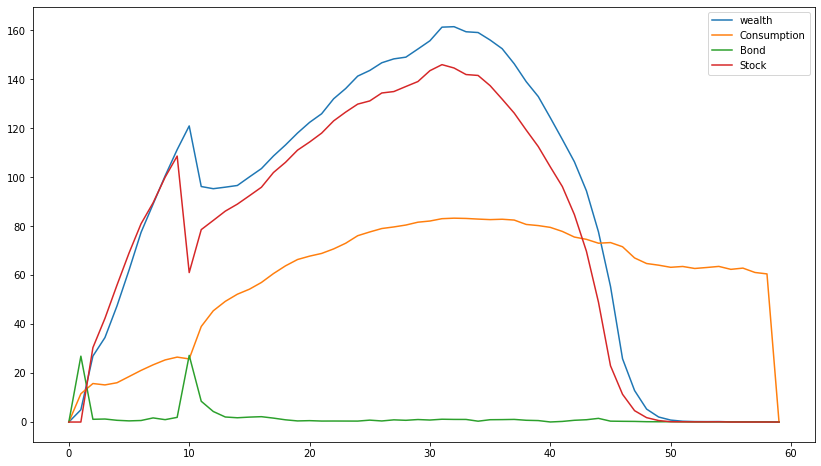

In [25]:
# mean value of the key variables
plt.figure(figsize = [14,8])
plt.plot(meanForPeopleWholive(ww), label = "wealth")
plt.plot(meanForPeopleWholive(cc), label = "Consumption")
plt.plot(meanForPeopleWholive(bb), label = "Bond")
plt.plot(meanForPeopleWholive(kk), label = "Stock")
plt.legend()

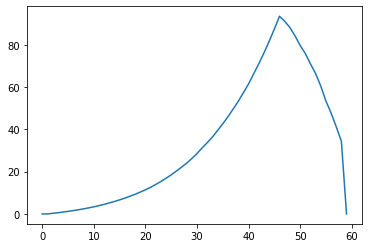

In [26]:
plt.plot(meanForPeopleWholive(nn), label = "401k")

In [27]:
Hgrid_renting.shape

(15, 10, 2, 27, 2, 60)

In [28]:
# Downpayment. 
for age in range(10,30):
    print(Hgrid_renting[:,9,1,10,1,age])

[   0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 2000.
 2000. 2000. 2000.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000. 200

In [29]:
np.array(H_options)*pt*0.2

array([  0.  ,  56.25,  75.  , 112.5 , 150.  ])

In [36]:
pt

0.375

In [30]:
plt.style.use('ggplot') # this was just used for the examples

def tsplot(x, y, n=5, percentile_min=2.5, percentile_max=97.5 , color='r', plot_mean=True, plot_median=False, line_color='k', **kwargs):
    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.percentile(y, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
    perc2 = np.percentile(y, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n
    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        plt.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)


    if plot_mean:
        plt.plot(x, np.mean(y, axis=0), color=line_color)


    if plot_median:
        plt.plot(x, np.median(y, axis=0), color=line_color)
    
    return plt.gca()

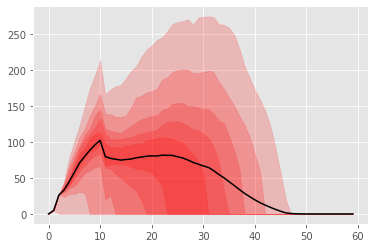

In [31]:
tsplot(np.linspace(0,59,60),np.transpose(ww))

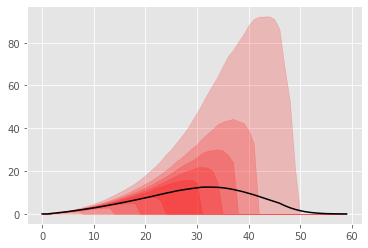

In [32]:
tsplot(np.linspace(0,59,60),np.transpose(nn))

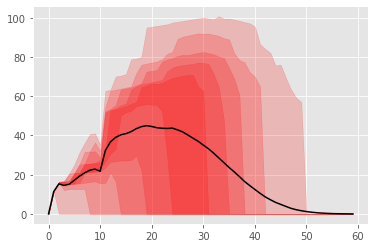

In [33]:
tsplot(np.linspace(0,59,60),np.transpose(cc))

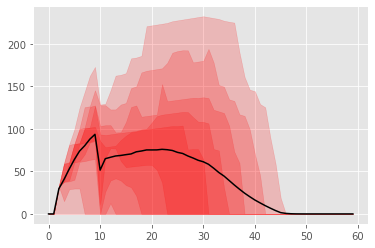

In [34]:
tsplot(np.linspace(0,59,60),np.transpose(kk))

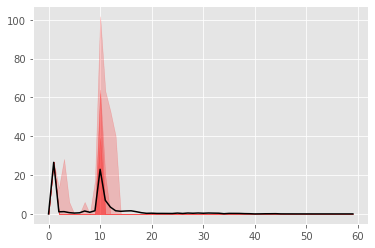

In [35]:
tsplot(np.linspace(0,59,60),np.transpose(bb))